In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
dsift_features = pickle.load(open('dsift_features.pickle', 'rb'))
dsift_labels = pickle.load(open('dsift_labels.pickle', 'rb'))

In [3]:
print(type(dsift_features), type(dsift_labels))
print(dsift_features.shape, len(dsift_labels))

<class 'numpy.ndarray'> <class 'list'>
(27000, 8192) 27000


In [7]:
dsift_center = dsift_features - dsift_features.mean()
dsift_labels = np.asarray(dsift_labels)
type(dsift_labels)

numpy.ndarray

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dsift_center, dsift_labels, test_size = 0.2, 
                                                    random_state = 423, stratify = dsift_labels)

In [9]:
def plot_PCA_2D(df, groups, group_labels, file = None, 
                n_components = 2, random_state = None):
    """
    Takes a centered DataFrame or array, conducts a principal components
    analysis (PCA), and plots the scores of the first two components colored
    by input group labels. Axis labels display the percentage of variance 
    explained by each component.

    Parameters
    ----------
    df: DataFrame or ndarray
    groups: Series or ndarray
        The groups to color the scores by
        length must equal df.shape[0]
    group_labels: one-dimensional array
        The unique labels for the groups
    file: string, default: None
        Filename to save plot output with
    n_components: int, default: 2
        The number of principal components to keep
    random_state: int, default: None

    Returns
    -------
    scatterplot
        scores plot of PC2 vs. PC1 colored by group_labels  
    """

    import matplotlib.pyplot as plt
    from itertools import cycle

    pca = PCA(n_components = n_components, random_state = random_state)
    pca.fit(df)
    scores = pca.transform(df)
    perc_var_explained = pca.explained_variance_ratio_

    colors = cycle(['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'w', 'aqua', 
                    'yellow', 'black', 'brown'])
    plt.figure(figsize = (12, 10))
    for c, label in zip(colors, group_labels):
        plt.scatter(scores[groups == label, 0], scores[groups == label, 1],
                    c = c, label = label, edgecolors = 'gray')
    plt.xlabel('PC1 ({}% Variance)'.format((100 * perc_var_explained[0])\
                .round(2)), fontsize = 15)
    plt.ylabel('PC2 ({}% Variance)'.format((100 * perc_var_explained[1])\
                .round(2)), fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend()

    if file:
        plt.savefig(file, dpi = 100, bbox_inches = 'tight')
    plt.show()
    plt.close()

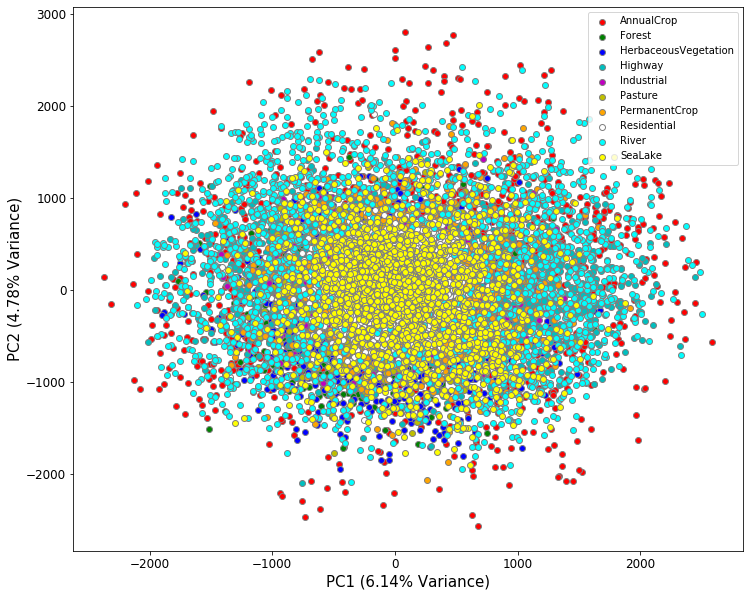

In [10]:
plot_PCA_2D(X_train, y_train, np.unique(y_train), random_state = 423, file = 'PCA_scores_dsift.png')

In [11]:
dsift_pca = PCA(n_components = 500, random_state = 423).fit(X_train)
dsift_train_scores = dsift_pca.transform(X_train)
dsift_test_scores = dsift_pca.transform(X_test)

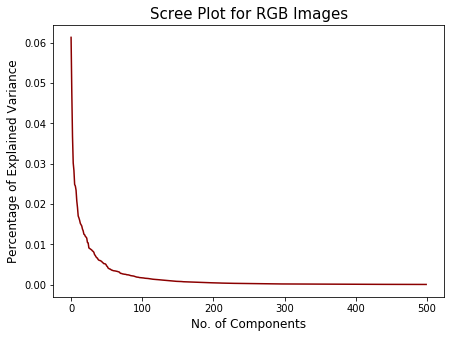

In [12]:
plt.figure(figsize = (7, 5))
plt.plot(dsift_pca.explained_variance_ratio_, color = 'darkred')
plt.xlabel('No. of Components', fontsize = 12)
plt.ylabel('Percentage of Explained Variance', fontsize = 12);
plt.title('Scree Plot for RGB Images', fontsize = 15)
plt.show()
plt.close()

In [13]:
np.min(np.where(np.cumsum(dsift_pca.explained_variance_ratio_) >= 0.9))

160

In [14]:
dsift_train_scores.shape

(21600, 500)

In [15]:
dsift_train_reduce = dsift_train_scores[:, 0:160]  # extract the first 160 PCs
dsift_test_reduce = dsift_test_scores[:, 0:160]

In [16]:
def display_clusters(data, model_fit = [], num_clusters = 0, file = None):
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'black', 'orange', 'aqua', 'yellow', 'brown']
    plt.figure(figsize = (12, 10))
    
    if num_clusters == 0:
        plt.scatter(data[:, 0], data[:, 1], c = color[0], alpha = 0.5, s = 20)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        
    else:
        for i in range(num_clusters):
            plt.scatter(data[model_fit.labels_ == i, 0], data[model_fit.labels_ == i, 1], 
                        c = color[i], alpha = 0.5, s = 20)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        
    if file:
        plt.savefig(file, dpi = 100, bbox_inches = 'tight')
    plt.show()
    plt.close()
        
        
def cluster_metrics(model_fit, labels, data):
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, model_fit.labels_)))
    print('Completeness: {}'.format(metrics.completeness_score(labels, model_fit.labels_)))
    print('V-measure: {}'.format(metrics.v_measure_score(labels, model_fit.labels_)))
    print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(data, model_fit.labels_,
                                                                 metric = 'euclidean')))

    
def print_contingency_matrix(contingency_matrix, class_names, figsize = (10,7), fontsize = 18):
    """
    Takes a contingency matrix as returned by sklearn.metrics.contingency_matrix and returns it
    as a heatmap.
    
    Parameters
    ---------
    contingency_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.contingency_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order that they index the given contingency matrix.
    figsize: tuple
        A 2-tuple, the first value determining the horizontal size of the output figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axis labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix heatmap
    """
    
    df_cm = pd.DataFrame(contingency_matrix, index = class_names, columns = class_names, )
    plt.figure(figsize = figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = 'viridis')
    except ValueError:
        raise ValueError("Contingency matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, 
                                 ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, 
                                 ha = 'right', fontsize = fontsize, rotation_mode = 'anchor')
    plt.ylabel('True Class', fontsize = 15, style = 'italic')
    plt.xlabel('Cluster Assignment', fontsize = 15, style = 'italic')
    
    plt.show()
    plt.close()

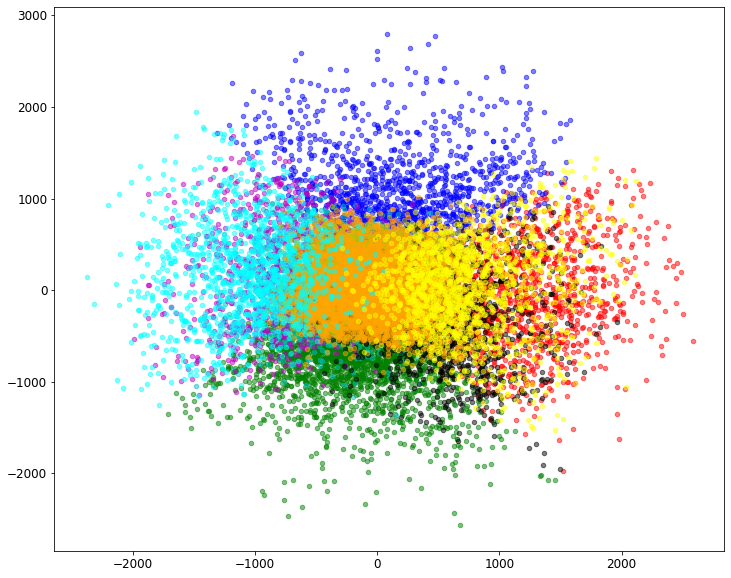

In [17]:
dsift_km = KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 423, n_jobs = -1)
dsift_km.fit(dsift_train_reduce)
display_clusters(dsift_train_reduce, dsift_km, num_clusters = 10, file = 'dsift_reduced_clusters_kmeans.png')

In [47]:
cluster_metrics(dsift_km, y_train, dsift_train_reduce)

Homogeneity: 0.13360674859773802
Completeness: 0.14453830180237445
V-measure: 0.1388577112831918
Silhouette Coefficient: 0.0004624678404070437


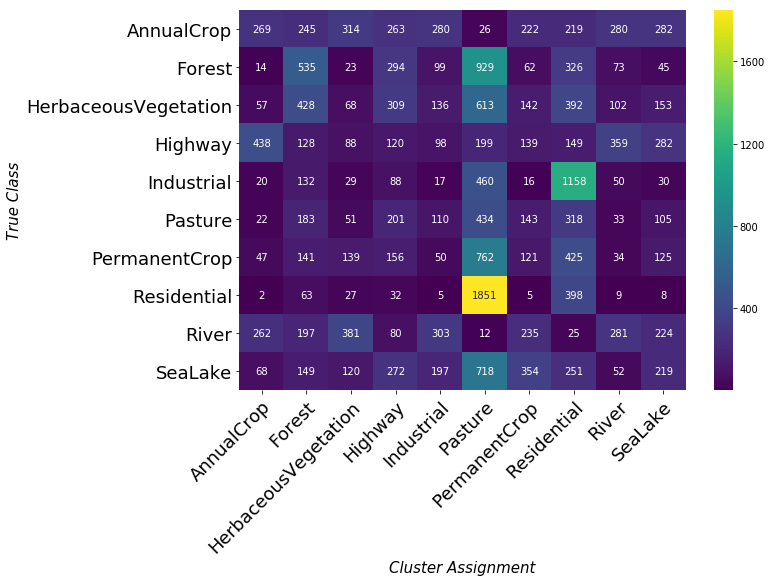

In [41]:
labels_unique = np.unique(y_train)
print_contingency_matrix(metrics.cluster.contingency_matrix(y_train, dsift_km.labels_), labels_unique)

In [48]:
inertia_scores = []
silhouette_coef = []
list_num_clusters = list(range(2, 21))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 8, random_state = 423, n_jobs = -1)
    km.fit(dsift_train_reduce)
    inertia_scores.append(km.inertia_)
    silhouette_coef.append(metrics.silhouette_score(dsift_train_reduce, km.labels_, metric = 'euclidean'))

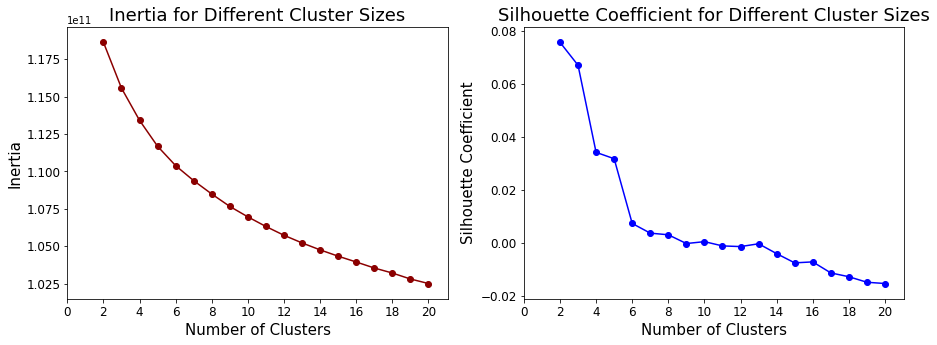

In [49]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(list_num_clusters, inertia_scores, color = 'darkred')
plt.scatter(list_num_clusters, inertia_scores, color = 'darkred')
plt.title('Inertia for Different Cluster Sizes', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 15)
plt.ylabel('Inertia', fontsize = 15)
plt.xticks(np.arange(0, 21, 2), fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(list_num_clusters, silhouette_coef, color = 'blue')
plt.scatter(list_num_clusters, silhouette_coef, color = 'blue')
plt.title('Silhouette Coefficient for Different Cluster Sizes', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 15)
plt.ylabel('Silhouette Coefficient', fontsize = 15)
plt.xticks(np.arange(0, 21, 2), fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()
plt.close()

In [51]:
pickle.dump(dsift_train_reduce, open('dsift_train_reduce.pickle', 'wb'))
pickle.dump(dsift_test_reduce, open('dsift_test_reduce.pickle', 'wb'))
pickle.dump(y_train, open('dsift_train_labels.pickle', 'wb'))
pickle.dump(y_test, open('dsift_test_labels.pickle', 'wb'))